In [1]:
%matplotlib inline
#%matplotlib notebook
#%matplotlib widget
import matplotlib 
import numpy as np
import pandas as pd
import os, sys
#import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection    
 
# use LaTeX, choose nice some looking fonts and tweak some settings
matplotlib.rc('font', family='serif')
matplotlib.rc('font', size=16)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('legend', handlelength=1.5)
matplotlib.rc('legend', frameon=False)
matplotlib.rc('xtick.major', pad=7)
matplotlib.rc('xtick.minor', pad=7)
matplotlib.rc('text', usetex=True)
# matplotlib.rc('text.latex', 
#               preamble=[r'\usepackage[T1]{fontenc}',
#                         r'\usepackage{amsmath}',
#                         r'\usepackage{txfonts}',
#                         r'\usepackage{textcomp}'])

matplotlib.rc('figure', figsize=(12, 9))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda:0')

IV. Logistic Regression
===

## 4.1 Logistic Regression

#### sigmoid function

$$
H(x) = \text{sigmoid} (Wx+b) = \dfrac{1}{1+e^{-(Wx+b)}} = \sigma(Wx+b)
$$

In [3]:
# sigmoid function

def sigmoid(x):
    return 1./(1.+np.exp(-x))

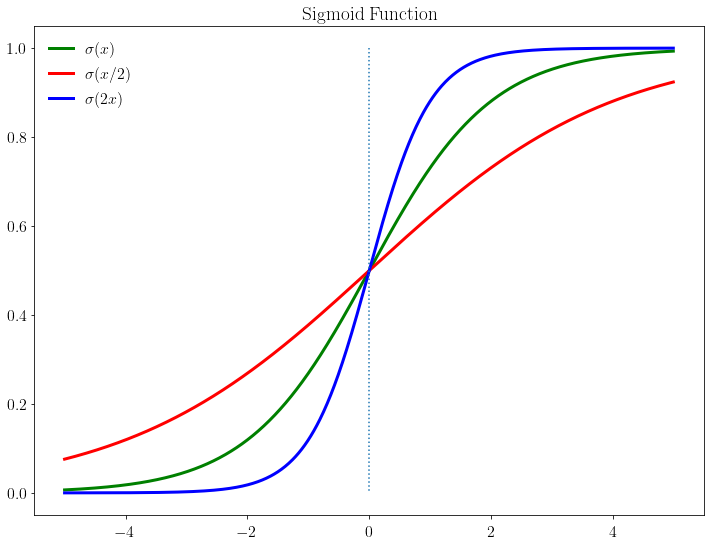

In [15]:
x=np.arange(-5.0, 5.0, 0.01)

plt.plot(x, sigmoid(x), 'g-', lw=3, label="$\sigma (x)$")
plt.plot(x, sigmoid(0.5*x), 'r-', lw=3, label = "$\sigma (x/2)$")
plt.plot(x, sigmoid(2.0*x), 'b-', lw=3, label = "$\sigma (2x)$")
plt.plot([0,0], [1.0, 0.0], ":")
plt.title("Sigmoid Function")
plt.legend()

#### Cost function

선형회귀에서 사용했던 아래와 같은 cost function을 사용한다고 하자

$$
\text{cost} (W,\, b) = \dfrac{1}{n} \sum_{i=1}^n \left[ y^{(i)}-H(x^{(i)}) \right]^2 = \dfrac{1}{n} \sum_{i=1}^n \left[y^{(i)}-\sigma (Wx^{(i)}+b)\right]^2
$$ 

이 비용함수는 $W$ 에 대해 많은 local minimum을 갖게 되므로 cost function에 적합하지 않다. 따라서 이 경우는 다음과 같은 cost function을 사용한다.

$$
\text{cost}(W) = − \sum_{i=1}^n \left[ y^{(i)} \log H(x^{(i)})+(1−y^{(i)}) \log (1−H(x^{(i)})) \right]
$$

In [5]:
torch.manual_seed(1)

x_data = [[1, 2], [2, 3], [3, 1], [4, 3], [5, 3], [6, 2]]
y_data = [[0], [0], [0], [1], [1], [1]]
x_train = torch.FloatTensor(x_data)
y_train = torch.FloatTensor(y_data)


# Wx 가 scalar가 되기 위해서는 W가 2x1 tensor 이어야 한다.
W = torch.zeros((2, 1), requires_grad=True) # 크기는 2 x 1
b = torch.zeros(1, requires_grad=True)

# optimizer 설정
optimizer = optim.SGD([W, b], lr=1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산
    hypothesis = torch.sigmoid(x_train.matmul(W) + b)
    cost = -(y_train * torch.log(hypothesis) + 
             (1 - y_train) * torch.log(1 - hypothesis)).mean()

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))


Epoch    0/1000 Cost: 0.693147
Epoch  100/1000 Cost: 0.134722
Epoch  200/1000 Cost: 0.080643
Epoch  300/1000 Cost: 0.057900
Epoch  400/1000 Cost: 0.045300
Epoch  500/1000 Cost: 0.037261
Epoch  600/1000 Cost: 0.031673
Epoch  700/1000 Cost: 0.027556
Epoch  800/1000 Cost: 0.024394
Epoch  900/1000 Cost: 0.021888
Epoch 1000/1000 Cost: 0.019852


In [6]:
cost

tensor(0.0199, grad_fn=<NegBackward>)

## 4.2 nn.Module로 구현하는 로지스틱 회귀

In [9]:
torch.manual_seed(1)

x_data = [[1, 2], [2, 3], [3, 1], [4, 3], [5, 3], [6, 2]]
y_data = [[0], [0], [0], [1], [1], [1]]
x_train = torch.FloatTensor(x_data)
y_train = torch.FloatTensor(y_data)

# nn.Sequential()은 nn.Module 층을 차례로 쌓을 수 있도록 합니다. 뒤에서 이를 
# 이용해서 인공 신경망을 구현하게 되므로 기억하고 있으면 좋습니다. 조금 쉽게 말해서 
# nn.Sequential()은 Wx+b와 같은 수식과 시그모이드 함수 등과 같은 여러 함수들을 
# 연결해주는 역할을 합니다. 이를 이용해서 로지스틱 회귀를 구현해봅시다.

model = nn.Sequential(
   nn.Linear(2, 1), # input_dim = 2, output_dim = 1
   nn.Sigmoid() # 출력은 시그모이드 함수를 거친다
)


# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    hypothesis = model(x_train)

    # cost 계산
    cost = F.binary_cross_entropy(hypothesis, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 50 == 0:
        prediction = hypothesis >= torch.FloatTensor([0.5]) # 예측값이 0.5를 넘으면 True로 간주
        correct_prediction = prediction.float() == y_train # 실제값과 일치하는 경우만 True로 간주
        accuracy = correct_prediction.sum().item() / len(correct_prediction) # 정확도를 계산
        print('Epoch {:4d}/{} Cost: {:.6f} Accuracy {:2.2f}%'.format( # 각 에포크마다 정확도를 출력
            epoch, nb_epochs, cost.item(), accuracy * 100,
        ))


Epoch    0/1000 Cost: 0.539713 Accuracy 83.33%
Epoch   50/1000 Cost: 0.266094 Accuracy 83.33%
Epoch  100/1000 Cost: 0.134272 Accuracy 100.00%
Epoch  150/1000 Cost: 0.100483 Accuracy 100.00%
Epoch  200/1000 Cost: 0.080486 Accuracy 100.00%
Epoch  250/1000 Cost: 0.067248 Accuracy 100.00%
Epoch  300/1000 Cost: 0.057820 Accuracy 100.00%
Epoch  350/1000 Cost: 0.050753 Accuracy 100.00%
Epoch  400/1000 Cost: 0.045251 Accuracy 100.00%
Epoch  450/1000 Cost: 0.040843 Accuracy 100.00%
Epoch  500/1000 Cost: 0.037228 Accuracy 100.00%
Epoch  550/1000 Cost: 0.034210 Accuracy 100.00%
Epoch  600/1000 Cost: 0.031649 Accuracy 100.00%
Epoch  650/1000 Cost: 0.029449 Accuracy 100.00%
Epoch  700/1000 Cost: 0.027538 Accuracy 100.00%
Epoch  750/1000 Cost: 0.025862 Accuracy 100.00%
Epoch  800/1000 Cost: 0.024381 Accuracy 100.00%
Epoch  850/1000 Cost: 0.023061 Accuracy 100.00%
Epoch  900/1000 Cost: 0.021877 Accuracy 100.00%
Epoch  950/1000 Cost: 0.020810 Accuracy 100.00%
Epoch 1000/1000 Cost: 0.019843 Accuracy 10

In [14]:
list(model.parameters())

[Parameter containing:
 tensor([[3.2534, 1.5181]], requires_grad=True),
 Parameter containing:
 tensor([-14.4839], requires_grad=True)]

## 4.3 Class로 구현한 로지스틱 회귀

In [15]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))


In [17]:
model = BinaryClassifier()

# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    hypothesis = model(x_train)

    # cost 계산
    cost = F.binary_cross_entropy(hypothesis, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 50 == 0:
        prediction = hypothesis >= torch.FloatTensor([0.5]) # 예측값이 0.5를 넘으면 True로 간주
        correct_prediction = prediction.float() == y_train # 실제값과 일치하는 경우만 True로 간주
        accuracy = correct_prediction.sum().item() / len(correct_prediction) # 정확도를 계산
        print('Epoch {:4d}/{} Cost: {:.6f} Accuracy {:2.2f}%'.format( # 각 에포크마다 정확도를 출력
            epoch, nb_epochs, cost.item(), accuracy * 100,
        ))


Epoch    0/1000 Cost: 0.778947 Accuracy 33.33%
Epoch   50/1000 Cost: 0.268428 Accuracy 83.33%
Epoch  100/1000 Cost: 0.134716 Accuracy 100.00%
Epoch  150/1000 Cost: 0.100728 Accuracy 100.00%
Epoch  200/1000 Cost: 0.080641 Accuracy 100.00%
Epoch  250/1000 Cost: 0.067355 Accuracy 100.00%
Epoch  300/1000 Cost: 0.057899 Accuracy 100.00%
Epoch  350/1000 Cost: 0.050813 Accuracy 100.00%
Epoch  400/1000 Cost: 0.045299 Accuracy 100.00%
Epoch  450/1000 Cost: 0.040882 Accuracy 100.00%
Epoch  500/1000 Cost: 0.037261 Accuracy 100.00%
Epoch  550/1000 Cost: 0.034237 Accuracy 100.00%
Epoch  600/1000 Cost: 0.031672 Accuracy 100.00%
Epoch  650/1000 Cost: 0.029469 Accuracy 100.00%
Epoch  700/1000 Cost: 0.027556 Accuracy 100.00%
Epoch  750/1000 Cost: 0.025878 Accuracy 100.00%
Epoch  800/1000 Cost: 0.024394 Accuracy 100.00%
Epoch  850/1000 Cost: 0.023073 Accuracy 100.00%
Epoch  900/1000 Cost: 0.021888 Accuracy 100.00%
Epoch  950/1000 Cost: 0.020820 Accuracy 100.00%
Epoch 1000/1000 Cost: 0.019852 Accuracy 10